<a href="https://colab.research.google.com/github/amannarsaria4/fast.ai/blob/master/Lesson%203/(MyCode)lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Image Segmentation with CamVid

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

###Data

In [ ]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [ ]:
path_img = path/'images'
path_lab = path/'labels'

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype='str')
print(codes)

['Animal' 'Archway' 'Bicyclist' 'Bridge' 'Building' 'Car' 'CartLuggagePram' 'Child' 'Column_Pole' 'Fence'
 'LaneMkgsDriv' 'LaneMkgsNonDriv' 'Misc_Text' 'MotorcycleScooter' 'OtherMoving' 'ParkingBlock' 'Pedestrian' 'Road'
 'RoadShoulder' 'Sidewalk' 'SignSymbol' 'Sky' 'SUVPickupTruck' 'TrafficCone' 'TrafficLight' 'Train' 'Tree' 'Truck_Bus'
 'Tunnel' 'VegetationMisc' 'Void' 'Wall']


In [ ]:
f_names = get_image_files(path_img)
f_names[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_04950.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01290.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01020.png')]

In [ ]:
lbl_names = get_image_files(path_lab)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01950_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08580_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_007710_P.png')]

In [ ]:
get_y_fn = lambda x: path_lab/f'{x.stem}_P{x.suffix}'

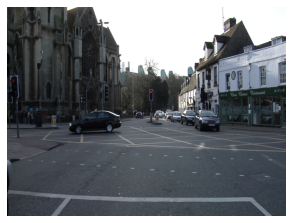

In [ ]:
img_f = f_names[0]
img = open_image(img_f)
img.show(figsize = (5,5))

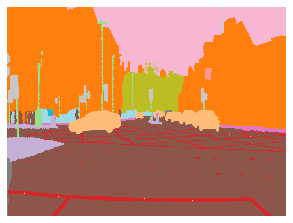

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha = 1)

In [ ]:
src_size =np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17],
          [22, 22, 22,  ..., 17, 17, 17]]]))

###Datasets

In [ ]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
free
if free>8000: bs = 4
else: bs = 2

In [ ]:
src = SegmentationItemList.from_folder(path_img).split_by_fname_file('../valid.txt').label_from_func(get_y_fn, classes = codes)

In [ ]:
data = src.transform(get_transforms(), size = size, tfm_y = True).databunch(bs = bs).normalize(imagenet_stats)

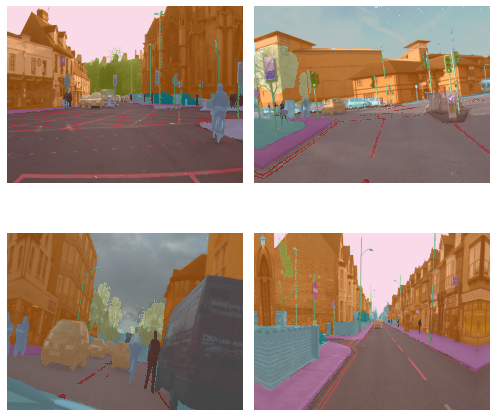

In [ ]:
data.show_batch(2,figsize = (7,7))

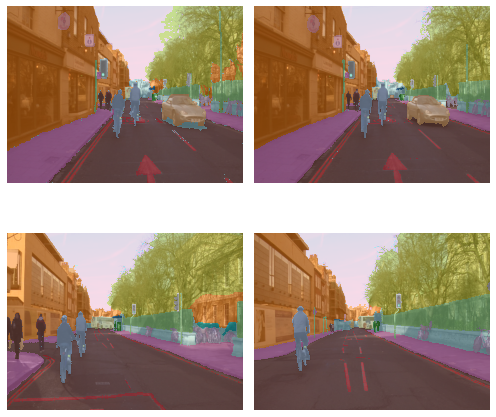

In [ ]:
data.show_batch(4, figsize = (7,7), ds_type = DatasetType.Valid)

###Model


In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics = acc_camvid

In [ ]:
wd = 1e-2

In [ ]:
learn = unet_learner(data, models.resnet34,metrics = metrics, wd = wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


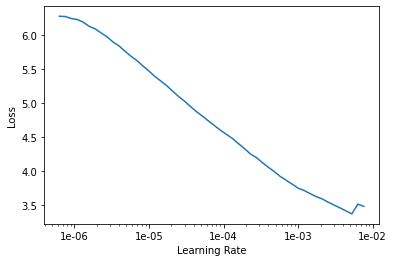

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start = 0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.022899,0.755865,0.811693,00:53
1,0.753169,0.672792,0.827294,00:53
2,0.654113,0.498936,0.867508,00:53
3,0.644410,0.526183,0.861366,00:53
4,0.595997,0.522623,0.868060,00:53
5,0.583566,0.481145,0.872790,00:53
6,0.571824,0.464068,0.883497,00:53
7,0.543111,0.372656,0.890319,00:53
8,0.532069,0.460497,0.882250,00:53
9,0.407177,0.296271,0.917871,00:53


In [ ]:
learn.save('stage-1')
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

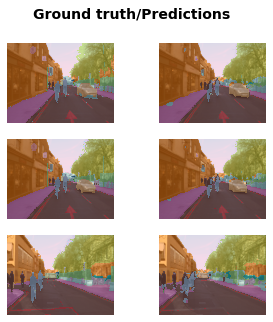

In [ ]:
learn.show_results(rows = 3, figsize = (5,5))

In [ ]:
learn.unfreeze()


In [ ]:
learn.fit_one_cycle(12, max_lr=slice(lr/400,lr/4))


epoch,train_loss,valid_loss,acc_camvid,time
0,0.375015,0.306449,0.910110,00:55
1,0.359721,0.304959,0.913213,00:56
2,0.359615,0.328491,0.908734,00:55
3,0.345824,0.317585,0.914262,00:55
4,0.322236,0.270188,0.925527,00:56
5,0.304828,0.279907,0.923632,00:56
6,0.281691,0.276439,0.920745,00:56
7,0.265669,0.277926,0.920161,00:56
8,0.257583,0.274849,0.924305,00:56
9,0.246955,0.260462,0.926767,00:55


In [ ]:
learn.save('stage-2')

###Bigger Model

In [ ]:
learn.destroy()

size = src_size//2

free = gpu_mem_get_free_no_cache()
if free>8000: bs = 2
else:     bs = 1

this Learner object self-destroyed - it still exists, but no longer usable


In [ ]:
data = src.transform(get_transforms(), tfm_y = True, size = size).databunch().normalize(imagenet_stats)

In [ ]:
learn = unet_learner(data, models.resnet34, wd =wd)

In [ ]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [ ]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,time


RuntimeError: ignored

In [ ]:
lr = 1e-1
learn.fit_one_cycle(10, slice(lr), pct_start = 0.8)

In [ ]:
learn.save('stage-1-big')
learn.load('stage-1-big')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr/100000,lr/100))

In [ ]:
learn.save('stage-2-big')
learn.load('stage-2-big')
learn.show_results(rows = 3,figsize = (7,7))